In [20]:
import random
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [21]:
# transform image to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load dataset
dataset = datasets.ImageFolder(root='dataset_1500', transform=transform)
print(dataset.class_to_idx)

# split dataset into train, validation and test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# check dataset size
print('train dataset size:', len(train_dataset))
print('val dataset size:', len(val_dataset))
print('test dataset size:', len(test_dataset))

for x, y in train_loader:
    print(x.shape, y.shape)
    break

{'red-billed-blue-magpie': 0, 'taiwan-blue-magpie': 1, 'yellow-billed-blue-magpie': 2}
train dataset size: 3150
val dataset size: 675
test dataset size: 675
torch.Size([32, 3, 256, 256]) torch.Size([32])


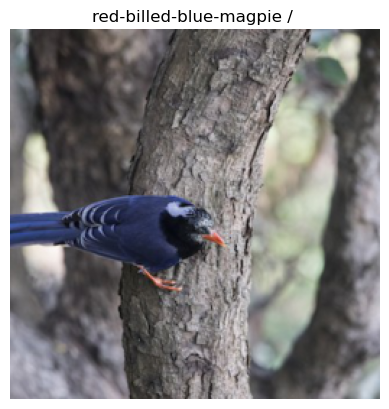

In [36]:
labels_map = {0: 'red-billed-blue-magpie', 1: 'taiwan-blue-magpie', 2: 'yellow-billed-blue-magpie'}

def imshow(img, label, pred=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title(labels_map[label] + ' / ' + (labels_map[pred] if pred is not None else ''))
    plt.show()

idx = random.randint(0, len(train_dataset))
imshow(train_dataset.dataset[idx][0], train_dataset.dataset[idx][1])

In [23]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('device:', device)

device: mps


In [ ]:
# custom CNN model
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=7)
        self.conv2 = torch.nn.Conv2d(6, 12, kernel_size=5)
        self.conv3 = torch.nn.Conv2d(12, 24, kernel_size=3)
        self.conv4 = torch.nn.Conv2d(24, 48, kernel_size=3)
        self.conv5 = torch.nn.Conv2d(48, 96, kernel_size=3)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.dropout = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(96 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 60)
        self.fc3 = torch.nn.Linear(60, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.dropout(x)
        x = x.view(-1, 96 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# model = SimpleCNN().to(device)

In [ ]:
# use existing model
model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512, 3)
model = model.to(device)

In [ ]:
# optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# training loop
def train(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_loss = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss.append(running_loss / len(train_loader))
        print(f'epoch: {epoch + 1}, train loss: {train_loss[-1]}')
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in tqdm(val_loader):
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                loss = criterion(y_hat, y)
                running_loss += loss.item()
                _, predicted = torch.max(y_hat, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        val_loss.append(running_loss / len(val_loader))
        val_acc.append(correct / total)
        print(f'epoch: {epoch + 1}, val loss: {val_loss[-1]}, val acc: {val_acc[-1]}')

    return train_loss, val_loss, val_acc

In [ ]:
# train model
train_loss, val_loss, val_acc = train(model, train_loader, val_loader, optimizer, criterion, epochs=10)

100%|██████████| 99/99 [00:46<00:00,  2.11it/s]


epoch: 1, train loss: 1.1149476507697442


100%|██████████| 22/22 [00:03<00:00,  5.96it/s]


epoch: 1, val loss: 1.1156781966036016, val acc: 0.44592592592592595


100%|██████████| 99/99 [00:40<00:00,  2.41it/s]


epoch: 2, train loss: 1.0428623033292366


100%|██████████| 22/22 [00:03<00:00,  6.03it/s]


epoch: 2, val loss: 1.0711338818073273, val acc: 0.4237037037037037


100%|██████████| 99/99 [00:40<00:00,  2.45it/s]


epoch: 3, train loss: 1.0277154620247657


100%|██████████| 22/22 [00:03<00:00,  6.41it/s]


epoch: 3, val loss: 1.0585521811788732, val acc: 0.46370370370370373


100%|██████████| 99/99 [00:41<00:00,  2.39it/s]


epoch: 4, train loss: 1.0197329328517721


100%|██████████| 22/22 [00:03<00:00,  6.34it/s]


epoch: 4, val loss: 1.0451741245659916, val acc: 0.43555555555555553


100%|██████████| 99/99 [00:42<00:00,  2.30it/s]


epoch: 5, train loss: 0.9849297319999849


100%|██████████| 22/22 [00:03<00:00,  6.39it/s]


epoch: 5, val loss: 0.9644656045870348, val acc: 0.5422222222222223


100%|██████████| 99/99 [00:41<00:00,  2.41it/s]


epoch: 6, train loss: 0.9622398843668928


100%|██████████| 22/22 [00:03<00:00,  5.97it/s]


epoch: 6, val loss: 0.9659434719519182, val acc: 0.5318518518518518


100%|██████████| 99/99 [00:40<00:00,  2.47it/s]


epoch: 7, train loss: 0.947173905493033


100%|██████████| 22/22 [00:03<00:00,  6.42it/s]


epoch: 7, val loss: 0.966450111432509, val acc: 0.5511111111111111


100%|██████████| 99/99 [00:40<00:00,  2.43it/s]


epoch: 8, train loss: 0.9278110801571547


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


epoch: 8, val loss: 1.0026014961979606, val acc: 0.554074074074074


100%|██████████| 99/99 [00:40<00:00,  2.42it/s]


epoch: 9, train loss: 0.9037597558715127


100%|██████████| 22/22 [00:03<00:00,  5.97it/s]


epoch: 9, val loss: 0.9851920550519769, val acc: 0.562962962962963


100%|██████████| 99/99 [00:41<00:00,  2.38it/s]


epoch: 10, train loss: 0.8722452966853825


100%|██████████| 22/22 [00:03<00:00,  6.02it/s]

epoch: 10, val loss: 0.9139311611652374, val acc: 0.5748148148148148


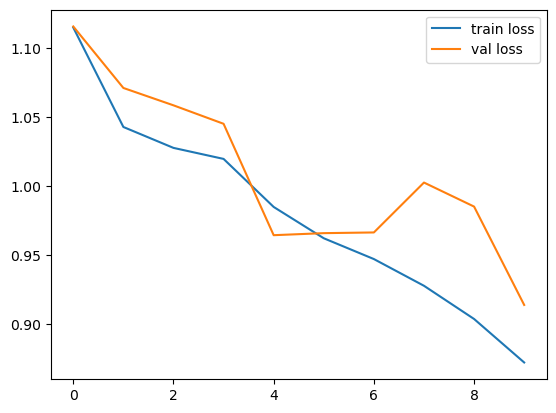

In [44]:
# plot loss and accuracy
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.show()

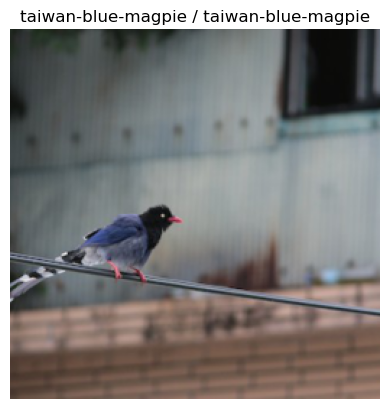

In [45]:
# test model
idx = random.randint(0, len(test_dataset))
x, y = test_dataset[idx]
x = x.unsqueeze(0).to(device)
y_hat = model(x)
_, predicted = torch.max(y_hat, 1)
imshow(x[0].cpu(), y, predicted.item())